Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
R² Score: 0.9545
Root Mean Squared Error (RMSE): 0.8372


<ipython-input-27-9270acc530aa>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  generic_RFL_results = X_test.groupby('SYNOPCode_reconstructed').apply(


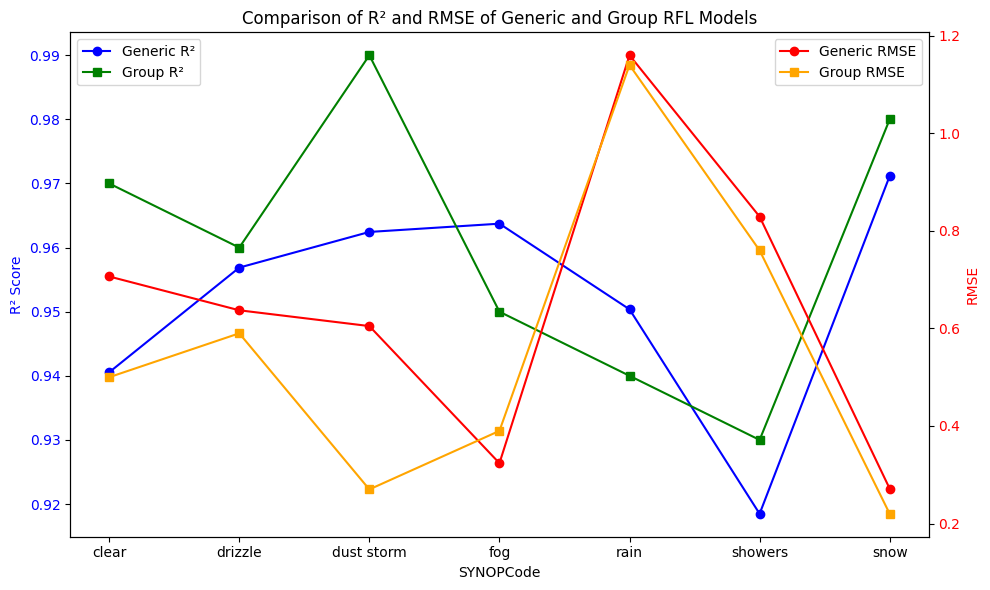

In [27]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
downsample_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final project/downsample_df.csv')

# Separate the features and target variable
target = downsample_data['RFL_Att']

features = downsample_data[[
    'Time', 'RelativeHumidity', 'Visibility', 'Frequency', 'VisibilityMax',
    'SYNOPCode', 'VisibilityMin', 'TemperatureMin', 'ParticulateMin', 'Temperature',
    'Particulate', 'AbsoluteHumidityMin', 'TemperatureMax', 'ParticulateMax',
    'RainIntensityMin', 'AbsoluteHumidityMax', 'RainIntensityMax', 'Distance',
    'RainIntensity', 'AbsoluteHumidity'
]]

# One-Hot Encoding for SYNOPCode without dropping the first category
features_encoded = pd.get_dummies(features, columns=['SYNOPCode'], drop_first=False)

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, test_size=0.3, random_state=42
)

# Train the Extra Trees Regressor
etr_model = ExtraTreesRegressor(random_state=42)
etr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = etr_model.predict(X_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the evaluation results
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Add predictions to the test set for evaluation
X_test['RFL_Att_actual'] = y_test
X_test['RFL_Att_pred'] = y_pred

# Identify the one-hot encoded SYNOPCode columns
synop_columns = [col for col in X_test.columns if col.startswith('SYNOPCode_')]

# Rebuild the original SYNOPCode from one-hot encoding by selecting the max column for each row
X_test['SYNOPCode_reconstructed'] = X_test[synop_columns].idxmax(axis=1).str.replace('SYNOPCode_', '')

# Group by the reconstructed SYNOPCode and calculate R² and RMSE
generic_RFL_results = X_test.groupby('SYNOPCode_reconstructed').apply(
    lambda x: pd.Series({
        'R2': r2_score(x['RFL_Att_actual'], x['RFL_Att_pred']),
        'RMSE': np.sqrt(mean_squared_error(x['RFL_Att_actual'], x['RFL_Att_pred']))
    })
).reset_index()

# Results from the second model (Optimal RFL Model)
group_RFL_results = pd.DataFrame({
    'SYNOPCode': ["clear", "dust storm", 'fog', 'drizzle', 'rain', 'snow', 'showers'],
    'Optimal_RMSE': [0.50, 0.27, 0.39, 0.59, 1.14, 0.22, 0.76],
    'Optimal_R2': [0.97, 0.99, 0.95, 0.96, 0.94, 0.98, 0.93]
})

# Merge both models' results for comparison
comparison_df = pd.merge(generic_RFL_results, group_RFL_results, left_on='SYNOPCode_reconstructed', right_on='SYNOPCode', how='outer')

# Create the line plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot R² on the primary y-axis (left axis) for both models
ax1.plot(comparison_df['SYNOPCode_reconstructed'], comparison_df['R2'], color='blue', label='Generic R²', marker='o')
ax1.plot(comparison_df['SYNOPCode_reconstructed'], comparison_df['Optimal_R2'], color='green', label='Group R²', marker='s')
ax1.set_xlabel('SYNOPCode')
ax1.set_ylabel('R² Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for RMSE
ax2 = ax1.twinx()
ax2.plot(comparison_df['SYNOPCode_reconstructed'], comparison_df['RMSE'], color='red', label='Generic RMSE', marker='o')
ax2.plot(comparison_df['SYNOPCode_reconstructed'], comparison_df['Optimal_RMSE'], color='orange', label='Group RMSE', marker='s')
ax2.set_ylabel('RMSE', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and labels
plt.title('Comparison of R² and RMSE of Generic and Group RFL Models')

# Show legend for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()


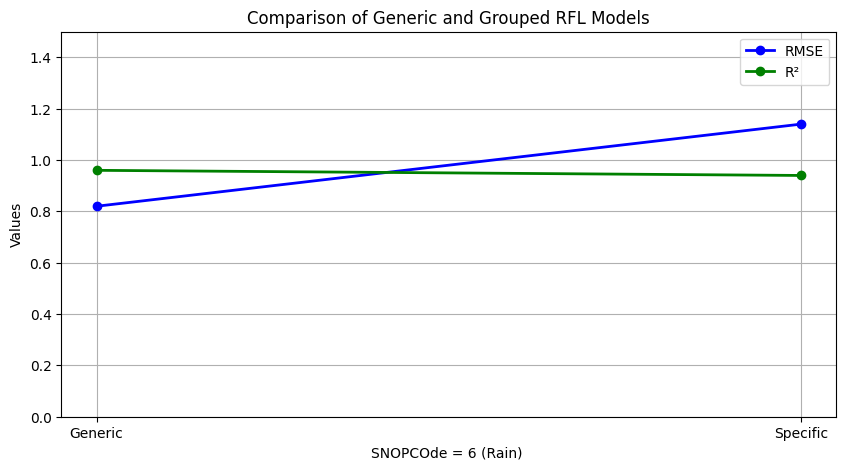

In [29]:
# worst case comparision


#SNOPCode 6(rain) has worst perfrmance in grop

import pandas as pd
import matplotlib.pyplot as plt

# Create the DataFrame
data = {
    'Model': ['Generic', 'Specific'],
    'RMSE': [0.82, 1.14],
    'R2': [0.96, 0.94]
}

df = pd.DataFrame(data)

# Set the figure size
plt.figure(figsize=(10, 5))

# Plot RMSE
plt.plot(df['Model'], df['RMSE'], marker='o', label='RMSE', color='b', linestyle='-', linewidth=2)

# Plot R²
plt.plot(df['Model'], df['R2'], marker='o', label='R²', color='g', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Comparison of Generic and Grouped RFL Models')
plt.xlabel('SNOPCOde = 6 (Rain) ')
plt.ylabel('Values')
plt.ylim(0, 1.5)  # Set y-axis limits for better visualization
plt.axhline(0, color='grey', lw=0.5)  # Add a horizontal line at y=0 for reference
plt.grid()


# Show legend
plt.legend()

# Show the plot
plt.show()
plt.show()
